In [34]:
using ITensors, ITensorMPS, Optim, LinearAlgebra, Printf, Random, Plots
Random.seed!(123)
include("src/QuantumResource1D.jl")
include("src/HL_module.jl")

N = 5

5

In [35]:
g_values = [-1.0]#range(-1.0, 1.0, 5)
all_params, all_costs, all_qr = [], [], []
all_X_exp, all_O_exp, all_ZZ_exp = [], [], []
fidelity_ghz_vals, fidelity_cluster_vals = [], []
λ_vals, delta_E_vals, H_params, HL_fidelities = [], [], [], []
all_O_HL_exp, all_ZZ_HL_exp = [], []

for g in g_values
    println("\n=== g = $g ===")

    qr_g = QR1D.QuantumResource1D(N)
    GHZ_wf, params_GHZ, name_GHZ = QR1D.generate_GHZ_state(qr_g)
    cluster_wf, params_cluster, name_cluster = QR1D.generate_cluster_state(qr_g)
    QR1D.AddQR(qr_g, GHZ_wf, params_GHZ, name_GHZ)
    QR1D.AddQR(qr_g, cluster_wf, params_cluster, name_cluster);

    θ_g, cost_g = QR1D.optimize_circuit_QR(qr_g, g)
    psi_g = QR1D.apply_ladder_circuit(qr_g, θ_g)

    hl = HL1D.HamiltonianLearner(psi_g)
    λ_min, v_min = HL1D.LearnHamiltonian_corr_mat(hl)

    push!(all_params, θ_g)
    push!(all_costs, cost_g)
    push!(all_qr, qr_g)
    push!(all_X_exp, real(inner(psi_g', qr_g.aux_ops[1], psi_g)))
    push!(all_O_exp, real(inner(psi_g', qr_g.aux_ops[2], psi_g)))
    push!(all_ZZ_exp, real(inner(psi_g', qr_g.aux_ops[3], psi_g)))
    push!(fidelity_ghz_vals, abs2(inner(psi_g, GHZ_wf)))
    push!(fidelity_cluster_vals, abs2(inner(psi_g, cluster_wf)))

    push!(λ_vals, λ_min)
    push!(H_params, v_min)
    push!(delta_E_vals, hl.E_psi - hl.E_GS)
    push!(HL_fidelities, hl.Fidelity)

    push!(all_O_HL_exp, real(inner(hl.ψ_GS', qr_g.aux_ops[2], hl.ψ_GS)))
    push!(all_ZZ_HL_exp, real(inner(hl.ψ_GS', qr_g.aux_ops[3], hl.ψ_GS)))
end



=== g = -1.0 ===
Fidelity wrt to GHZ = 1.0
Fidelity wrt to cluster state = 1.0
Optimizing for g = -1.0...
Iter     Function value   Gradient norm 
     0     1.917353e-32     1.167199e-11
 * time: 7.510185241699219e-5
Optimizing for g = -1.0...
Iter     Function value   Gradient norm 
     0    -1.000000e+00     4.308552e-09
 * time: 5.602836608886719e-5
Degeneracy = 4
After sweep 1 energy=-2.999999996501487  maxlinkdim=2 maxerr=3.88E-16 time=0.003
After sweep 2 energy=-2.999999996501487  maxlinkdim=2 maxerr=3.92E-16 time=0.001
After sweep 3 energy=-2.9999999965015434  maxlinkdim=2 maxerr=4.24E-16 time=0.001
After sweep 4 energy=-2.9999999965122432  maxlinkdim=2 maxerr=3.52E-16 time=0.007
After sweep 5 energy=-2.999999996642428  maxlinkdim=2 maxerr=3.29E-16 time=0.001
After sweep 6 energy=-2.999999996669509  maxlinkdim=2 maxerr=4.09E-16 time=0.001
After sweep 7 energy=-2.999999996682813  maxlinkdim=2 maxerr=3.85E-16 time=0.001
After sweep 8 energy=-2.9999999966907795  maxlinkdim=2 max

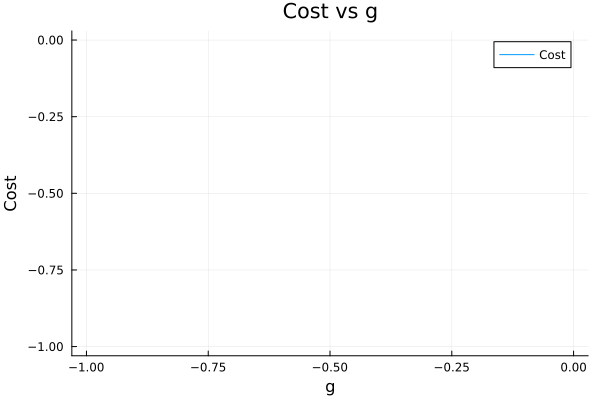

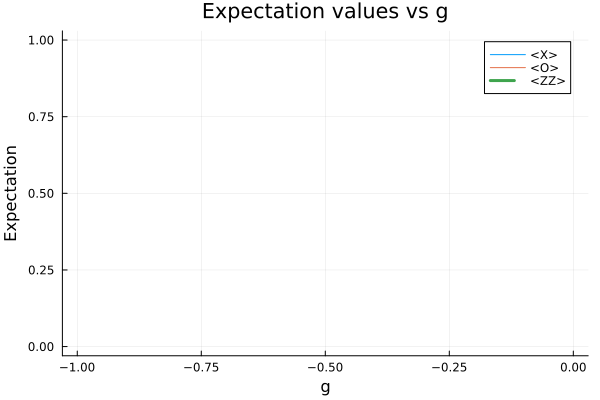

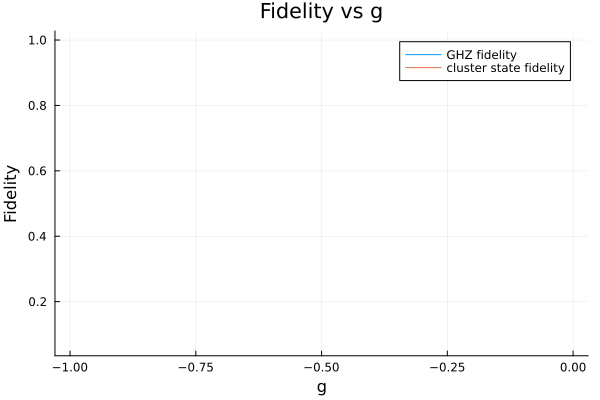

fidelity_ghz_vals = Any[0.062499999836197986]
fidelity_cluster_vals = Any[0.9999999999999997]


1-element Vector{Any}:
 0.9999999999999997

In [36]:
p1 = plot(g_values, all_costs, label="Cost", title="Cost vs g", xlabel="g", ylabel="Cost");
p2 = plot(g_values, all_X_exp, label="<X>", title="Expectation values vs g", xlabel="g", ylabel="Expectation",linewidth=1);
plot!(p2, g_values, all_O_exp, label="<O>",linewidth=1);
plot!(p2, g_values, all_ZZ_exp / (N - 1), label="<ZZ>",linestyle=:dash,linewidth=3);

p3 = plot(g_values, fidelity_ghz_vals, label="GHZ fidelity", title="Fidelity vs g", xlabel="g", ylabel="Fidelity");
plot!(p3, g_values, fidelity_cluster_vals, label="cluster state fidelity");

display(p1)
display(p2)
display(p3)

@show fidelity_ghz_vals
@show fidelity_cluster_vals

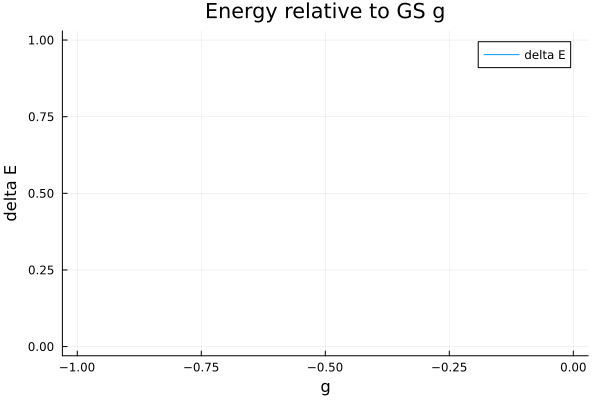

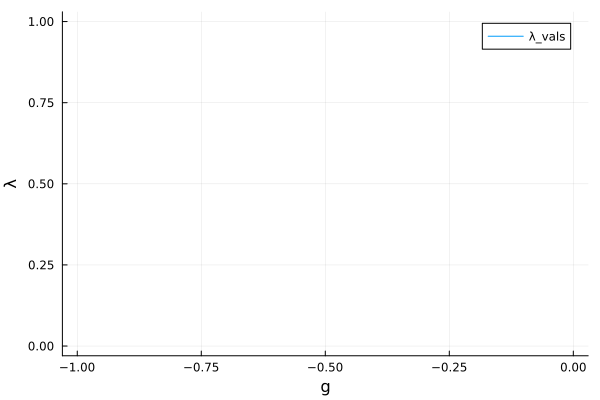

In [37]:
#Verify that the state is the GS of the learned H
pl1 = plot(g_values, delta_E_vals, label="delta E", title="Energy relative to GS g", xlabel="g", ylabel="delta E")
pl2 = plot(g_values, λ_vals, label="λ_vals", xlabel="g", ylabel="λ")

display(pl1)
display(pl2)


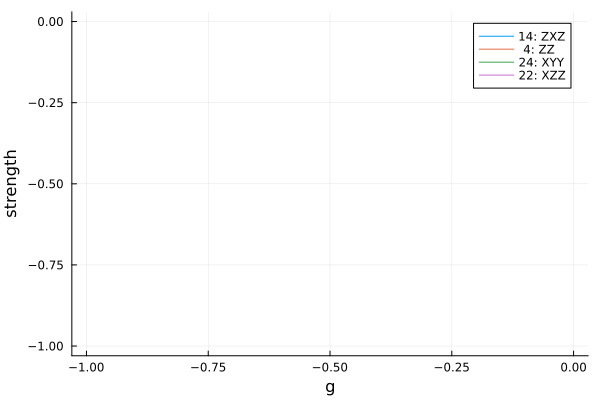

In [38]:
#Analsysis of the learned H
param4_vals = [v[4] for v in H_params]
param14_vals = [v[14] for v in H_params]
param24_vals = [v[24] for v in H_params]
param21_vals = [v[21] for v in H_params]

param22_vals = [v[22] for v in H_params]
param23_vals = [v[23] for v in H_params]

pl1 = plot(g_values, param14_vals, label="14: ZXZ", xlabel="g", ylabel="strength")
plot!(pl1, g_values, param4_vals, label=" 4: ZZ", xlabel="g", ylabel="strength")
plot!(pl1, g_values, param24_vals, label="24: XYY", xlabel="g", ylabel="strength")
plot!(pl1, g_values, param22_vals, label="22: XZZ", xlabel="g", ylabel="strength")




In [39]:
ind = 6

v = H_params[ind]

bar(1:length(v), v;
    xlabel="Index",
    ylabel="learned H",
    legend=false,
    lw=2,
    ylim=(-1.1, 1.1),
    title="Hamiltonian for g = $(g_values[ind])"
    )

BoundsError: BoundsError: attempt to access 1-element Vector{Any} at index [6]

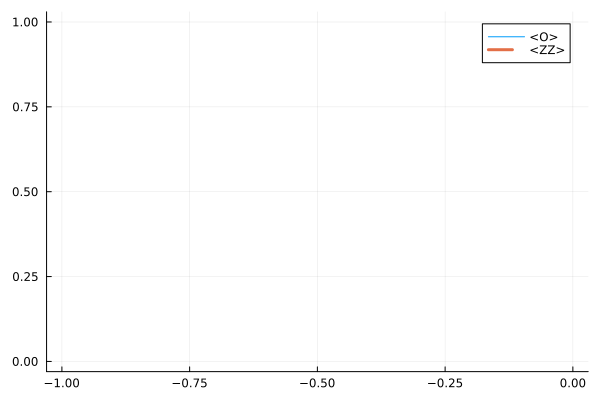

In [40]:
d = plot(g_values, all_O_HL_exp, label="<O>",linewidth=1);
plot!(d, g_values, all_ZZ_HL_exp / (N - 1), label="<ZZ>",linestyle=:dash,linewidth=3);

display(d)


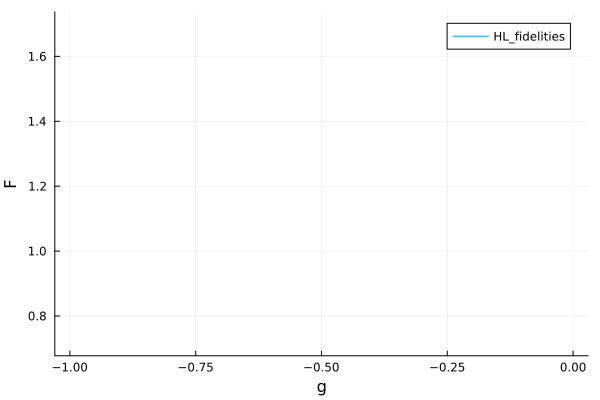

In [41]:
plot(g_values, HL_fidelities, label="HL_fidelities", xlabel="g", ylabel="F")

In [52]:
using ITensors, ITensorMPS, Optim, LinearAlgebra, Printf, Random, Plots
Random.seed!(123)
include("src/QuantumResource1D.jl")
include("src/HL_module.jl")

qr = QR1D.QuantumResource1D(N)
ind_g = 1
# θ = all_params[ind_g]
cluster_wf, params_cluster, name_cluster = QR1D.generate_cluster_state(qr)

psi = QR1D.apply_ladder_circuit(qr, params_cluster)

@show real(inner(psi, qr.aux_ops[1], psi) )
@show real(inner(psi, qr.aux_ops[2], psi) )
@show real(inner(psi, qr.aux_ops[3], psi) )

@show all_X_exp[ind_g]
@show all_O_exp[ind_g]
@show all_ZZ_exp[ind_g]


hl = HL1D.HamiltonianLearner(psi)
λ_min, v_min = HL1D.LearnHamiltonian_corr_mat(hl)



Fidelity wrt to cluster state = 1.0


real(inner(psi, qr.aux_ops[1], psi)) = 1.0347703314036335e-17
real(inner(psi, qr.aux_ops[2], psi)) = 1.0000000000000002
real(inner(psi, qr.aux_ops[3], psi)) = -1.7659319601674776e-9
all_X_exp[ind_g] = 1.0347703314036335e-17
all_O_exp[ind_g] = 1.0000000000000002
all_ZZ_exp[ind_g] = -1.7659319601674776e-9
Degeneracy = 4
After sweep 1 energy=-2.999999996501487  maxlinkdim=2 maxerr=3.88E-16 time=0.002
After sweep 2 energy=-2.999999996501487  maxlinkdim=2 maxerr=3.92E-16 time=0.001
After sweep 3 energy=-2.9999999965015434  maxlinkdim=2 maxerr=4.24E-16 time=0.002
After sweep 4 energy=-2.9999999965122432  maxlinkdim=2 maxerr=3.52E-16 time=0.007
After sweep 5 energy=-2.999999996642428  maxlinkdim=2 maxerr=3.29E-16 time=0.002
After sweep 6 energy=-2.999999996669509  maxlinkdim=2 maxerr=4.09E-16 time=0.002
After sweep 7 energy=-2.999999996682813  maxlinkdim=2 maxerr=3.85E-16 time=0.001
After sweep 8 energy=-2.9999999966907795  maxlinkdim=2 maxerr=5.00E-16 time=0.002
Fidelity = 0.7073273535655066

-0.9999999988338284

In [55]:
v_min[14] = 0.0

norm(v_min)

4.829434051112047e-5

In [46]:
@show inner(hl.ψ_GS, hl.H, hl.ψ_GS)
@show inner(psi, hl.H, psi)
@show abs2(inner(psi, hl.ψ_GS))
@show hl.Fidelity

inner(hl.ψ_GS, hl.H, hl.ψ_GS) = -2.9999999966907804 - 8.207318677701733e-17im


ErrorException: MPO A and MPS B must share site indices. On site 1, A has site indices Index{Int64}[(dim=2|id=775|"S=1/2,Site,n=1")', (dim=2|id=775|"S=1/2,Site,n=1")] while B has site indices Index{Int64}[(dim=2|id=256|"S=1/2,Site,n=1")].

In [47]:
psi0 = randomMPS(hl.sites, linkdims=10)
maxdim_schedule = [10, 20, 100, 200, 400, 800, 800, 800]
sweeps = Sweeps(length(maxdim_schedule))
maxdim!(sweeps, maxdim_schedule...)
cutoff!(sweeps, 1e-10)

E0, ψ0 = dmrg(hl.H, psi0, sweeps)

@show abs2(inner(ψ0, hl.ψ_GS))
@show abs2(inner(ψ0, hl.psi))

After sweep 1 energy=-2.999999994391736  maxlinkdim=4 maxerr=1.56E-15 time=0.004
After sweep 2 energy=-2.999999996501617  maxlinkdim=4 maxerr=1.46E-16 time=0.013
After sweep 3 energy=-2.999999996501618  maxlinkdim=4 maxerr=1.35E-16 time=0.002
After sweep 4 energy=-2.999999996501657  maxlinkdim=4 maxerr=7.63E-17 time=0.004
After sweep 5 energy=-2.9999999965033166  maxlinkdim=4 maxerr=1.13E-15 time=0.002
After sweep 6 energy=-2.9999999965033797  maxlinkdim=4 maxerr=1.29E-15 time=0.003
After sweep 7 energy=-2.9999999965034214  maxlinkdim=4 maxerr=0.00E+00 time=0.004
After sweep 8 energy=-2.9999999965034494  maxlinkdim=4 maxerr=9.86E-17 time=0.004
abs2(inner(ψ0, hl.ψ_GS)) = 0.005733701447494974
abs2(inner(ψ0, hl.psi)) = 0.0011832818589010852


0.0011832818589010852

In [ ]:
g_values = [-1.0]#range(-1.0, 1.0, 5)
all_params, all_costs, all_qr = [], [], []
all_X_exp, all_O_exp, all_ZZ_exp = [], [], []
fidelity_ghz_vals, fidelity_cluster_vals = [], []
λ_vals, delta_E_vals, H_params, HL_fidelities = [], [], [], []
all_O_HL_exp, all_ZZ_HL_exp = [], []

for g in g_values
    println("\n=== g = $g ===")

    qr_g = QR1D.QuantumResource1D(N)
    GHZ_wf, params_GHZ, name_GHZ = QR1D.generate_GHZ_state(qr_g)
    cluster_wf, params_cluster, name_cluster = QR1D.generate_cluster_state(qr_g)
    QR1D.AddQR(qr_g, GHZ_wf, params_GHZ, name_GHZ)
    QR1D.AddQR(qr_g, cluster_wf, params_cluster, name_cluster);

    θ_g, cost_g = QR1D.optimize_circuit_QR(qr_g, g)
    psi_g = QR1D.apply_ladder_circuit(qr_g, θ_g)

    hl = HL1D.HamiltonianLearner(psi_g)
    λ_min, v_min = HL1D.LearnHamiltonian_corr_mat(hl)

    push!(all_params, θ_g)
    push!(all_costs, cost_g)
    push!(all_qr, qr_g)
    push!(all_X_exp, real(inner(psi_g', qr_g.aux_ops[1], psi_g)))
    push!(all_O_exp, real(inner(psi_g', qr_g.aux_ops[2], psi_g)))
    push!(all_ZZ_exp, real(inner(psi_g', qr_g.aux_ops[3], psi_g)))
    push!(fidelity_ghz_vals, abs2(inner(psi_g, GHZ_wf)))
    push!(fidelity_cluster_vals, abs2(inner(psi_g, cluster_wf)))

    push!(λ_vals, λ_min)
    push!(H_params, v_min)
    push!(delta_E_vals, hl.E_psi - hl.E_GS)
    push!(HL_fidelities, hl.Fidelity)

    push!(all_O_HL_exp, real(inner(hl.ψ_GS', qr_g.aux_ops[2], hl.ψ_GS)))
    push!(all_ZZ_HL_exp, real(inner(hl.ψ_GS', qr_g.aux_ops[3], hl.ψ_GS)))
end
